{'p_s1': 0.02, 'p_e1': 0.25, 'ship': 0.04, 'GM': 0.7, 'repair': 0.1, 'salvage': 0.1, 'test': 0.03, 'remade': 0.3, 'vlosscoeff': 0.6, 'delta': 0.1, 'rho': 0.8, 'gamma': 0.6, 'm': 10, 'q': 0.6}
['m2', [0.0, 40, 0.4]]
[10, 9, 9, 8, 8, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


Text(0, 0.5, 'Strikes')

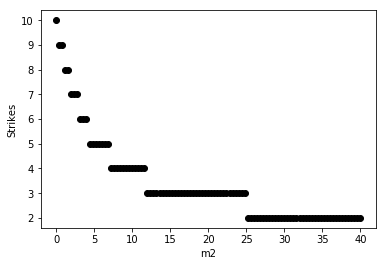

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import mdptoolbox

#*****************************************************************************************************************************
# states 0-20, state '0' being the original new product. the rest of the states are divided into 5 stages (1-5) with
# a multiple of 4 states each denoted by the script following the stage. Eg 1-o is when the product is reshipped successfully, 
#1-x is product is returned by customer, 1-r the product is repaired and sent to be reshipped as a refurbished product and 
#1-e is the product is sent to be destroyed (trashed). therefore in this scheme states 1 to 4 correspond to 1-o, 1-x, 1-r and 1-e
# respectively Similarly 5-8, 9-12....17-20 correspond to stages 2,3,4 and 5 respectively.

#******************************************************************************************************************************
# Parameters to be tested are- prob of ship back- p_s1, prob of finding a defect p_e1,  
# costs for -test ship repair and salvage,and refurbished values at each stage. Below in the variable parameters we provide the
# default value and the corresponding min and max value til which we run sensitivity analysis by varying it. For eg if I say 
# p_s1 = (0.02,[0,1,0.01] this means the prob of shipment being returned at first stage (p_s1) is varied from 0 to 1 in steps of 0.01.
#The corresponding probability of the shipment being returned will change correspondingly for each value of p_s1 by increasing 
#2% per stage (to a max of 1). All these can be manipulated using the variable parameters.
#******************************************************************************************************************************

parameters ={'p_s1':[0.02,[0.00,1,0.01]], 'p_e1':[0.25,[0.05,0.75,0.01]],'ship':[0.04,[0.0,1,0.01]], 'GM':[0.7,[0.3,1,0.01]],\
             'repair':[0.1,[0.05,0.25,0.01]],'salvage':[0.1,[0.01,0.2,0.01]],'test':[0.03,[0.01,0.1,0.005]],\
             'remade':[0.3,[0.1,0.8,0.01]],'vlosscoeff':[0.6,[0.01,1,0.01]],'delta':[0.1,[-1,1,0.01]],\
             'rho':[0.8,[0,1,0.01]],'gamma':[0.6,[0.0,1,0.01]],'m':[10,[0.0,100,1]],'q':[0.6,[0.0,1,0.01]],'m2':[4,[0.0,40,0.4]]}
runSensitivity ="m2"
def setparameter(runSensitivity):
    variable ={}
    independent =[]
    if runSensitivity not in parameters.keys():
        print ("This parameter does not exist. Check and re run the code")
    else:
        for x,y in parameters.items():
            if x != runSensitivity:
                variable[x] =y[0]
            else: 
                independent =[x, y[1]]
    return variable, independent
#******************************************************************************************************************************
#******************************************************************************************************************************
def runMDP(variables, param):
    S = list(range(101))
    A = ["SHIP","TRASH"]
    V_0 =100 #For a  given product the Value is constant
    var= variables
    var.update(param)
    
# Parameters, prob of ship back- p_s1, prob of finding a defect p_e1, initial value of product V_0, 
# costs for test ship repair and salvage, Gross Margin (GM assumed to be 70% of V_0)  and refurbished values at each stage
    p_s1 = var.get('p_s1')
    p_e1 = var.get('p_e1')
    GM = var.get('GM')*V_0
    remade = var.get('remade')*V_0
    test = var.get('test')*V_0
    ship =var.get('ship')*V_0
    repair = var.get('repair')*V_0
    salvage = var.get('salvage')*V_0
    vlosscoeff = var.get('vlosscoeff') #( this is how much the value erodes per stage if the initial value was the GM, the next stage value
                # will be 0.7 times GM and so on. This represents the penalty caused by customer dissatisfaction expressed in 
                # monetary value. we could use any loss function which models this accurately. linear values decreases from
                # Gm to shipping cost or zero and so on per stage)
    #print(vlosscoeff)
    gamma = var.get('gamma')# Refurbished costs can be expressed as a percentage of the initial refurbished cost in each stage. We can assume
             #it stays a constant or perhaps it decreases by a constant factor gamma till it reaches a minimum threshold value 
             # of sigma >= repair costs ( 0<= gamma <= 1.Using 1 ensures a constant refurbished value)
    #print(gamma)
    delta = var.get('delta')
    rho = var.get('rho')
    m = var.get('m') # Make sure u change the Value and refurbished to the correct array calculator in the for loop
    m2 = var.get('m2')
    q = var.get('q')
#******************************************************************************************************************************
    Value=[]
    Value.append(GM)
    vthreshold = -200000 #ship 
    for i in range(1, len(S)//4):
        #Value.append(max(vlosscoeff*Value[i-1],vthreshold))
        #Value.append(Value[0]-m*i) # linear  (constt slope)
        #Value.append(Value[0]- q*np.square(i)) # quadratic decline
        Value.append(Value[i-1]-m2*i) #  linear piece wise decline (slope increases)
    
#******************************************************************************************************************************
    sigma =-200000 #repair 
    refurbished = []
    refurbished.append(remade) # initial value of the fraction of V_0
    for i in range(1,len(S)//4-1):
        #refurbished.append(max(refurbished[i-1]*gamma ,sigma)) #fractional decline
        #refurbished.append(refurbished[0]-m*i) # linear decline (constt slope)
        #refurbished.append(refurbished[0]-q*np.square(i)) # quadratic decline
        refurbished.append(refurbished[i-1]-m2*i) #  linear piece wise decline (slope increases)
#*****************************************************************************************************************************

#*****************************************************************************************************************************
# Prob_shipback is the return probability Assume it increases linearly (by a constant increase in probability) per stage with
# an increment of delta for eg if the prob is 2% in 1st stage (call it p_1)  then (p_5) could be 10%  in stage 5 (2%).(-1 <= delta <= 1)
    Prob_shipback = np.zeros(len(S)//4)
    #delta= 0.1 #(Using zero ensures a constant re-shipping probability = p_s1 at every stage)
    for x, val in enumerate(Prob_shipback):
        if x ==0:
            Prob_shipback[x] = p_s1
        else:
            Prob_shipback[x] = max(0,min((x*delta) + Prob_shipback[0] ,1) ) 
    #print(Prob_shipback)
#*****************************************************************************************************************************
# Prob_errorfound is the chance of finding an error at a stage, give that the customer has returned a product. We can again assume it is 
#linearly decreasing per stage as above. Let rho (0< rho <= 1) be a factor at each stage of return. (rho ==1 is constant, <1 is
# decreasing).
    #rho = 0.8 #(Using 1 ensures a constant probability = p_e1 of finding an error at every stage)
    Prob_errorfound = np.zeros(len(S)//4 -1)
    Prob_errorfound[0] = p_e1
    for x, val in enumerate(Prob_errorfound):
        if x !=0:
            Prob_errorfound[x] = min(rho*Prob_errorfound[x-1],1)
    #print(Prob_errorfound)
#*****************************************************************************************************************************
    TPM = np.zeros((len(A),len(S),len(S)))
    TPM.shape
    for x, val in enumerate(A):
        for y in S:
            for z in S:
                if y==0:
                    if x ==0:
                        TPM[x][y][2]=Prob_shipback[y]
                        TPM[x][y][1]=1- Prob_shipback[y]
                    else:
                        TPM[x][y][4]=1
                elif y%4 ==2 and y/4 <len(S)//4 -1:
                    if x == 0:
                        TPM[x][y][y+1]=Prob_errorfound[int(y/4)]
                        TPM[x][y][y+3]=(1- Prob_shipback[int(y/4+1)])*(1-Prob_errorfound[int(y/4)])
                        TPM[x][y][y+4]=Prob_shipback[int(y/4+1)]*(1-Prob_errorfound[int(y/4)])
                    else:
                        TPM[x][y][y+2]=1
                elif float(y/4)>float(len(S)//4 -1):
                    TPM[x][y][y]=1
                elif y==z:
                    TPM[x][y][y]=1
    #print(TPM)
#*****************************************************************************************************************************
# Let V_0 be the initial value of the product (in $). When it is first shipped and accepted the reward is gross margin x V_0
# Subsequently the rewards depend on the state as the cost of testing repairs, salvage (if applicable) and reshipping are added, which
# diminish the value of the product as number of stages increases. The refurbished value is again a fraction of the present value of 
# the product in the previous stage
    Reward = -np.zeros((len(A),len(S),len(S)))
    Reward.shape
    for x, val in enumerate(A):
        for y in S:
            for z in S:
                if y ==0:
                    if x ==0:
                        Reward[x][y][2]=-test
                        Reward[x][y][1]= Value[0]
                    else:
                        Reward[x][y][4]= -salvage
                elif y%4 ==2 and y/4 <len(S)//4 -1:
                    if x == 0:
                        Reward[x][y][y+1]=-repair+ refurbished[int(y/4)]
                        Reward[x][y][y+4]=-(ship+ test)
                        Reward[x][y][y+3]=-ship+ Value[int(y/4+1)]
                    else:
                        Reward[x][y][y+2]=-salvage
    beta = 0.999999999
#******************************************************************************************************************************
#Policy Iteration
#grid = mdptoolbox.mdp.PolicyIteration(TPM, Reward, beta)
#grid.run()
#print(grid.policy) 
#print(grid.V)
#print(grid.iter) 
#print(grid.time)
#******************************************************************************************************************************
#Value iteration
    grid = mdptoolbox.mdp.ValueIteration(TPM, Reward, beta)
    grid.run()
    #print(grid.V)
    policy=[]
    policy.append(grid.policy[0])
    for i in range(0,len(grid.policy)-1,1):
        if i%4 ==2:
             policy.append(grid.policy[i])
    strikes = np.argmax(policy)
    if strikes==0:
        strikes =-1
    return strikes
#******************************************************************************************************************************
#******************************************************************************************************************************
variables,sensitivevariable = setparameter(runSensitivity)
if variables=={}:
    print("TERMINATE")
    exit()
else:
    print(variables)
    print(sensitivevariable)
    counter =0
    cmax = int((sensitivevariable [1][1]-sensitivevariable [1][0])/sensitivevariable [1][2])
    paramvalue=[]
    outputMDP =[]
    while (counter <= cmax):
        param ={sensitivevariable[0]: sensitivevariable[1][0]+ counter* sensitivevariable[1][2]}
        paramvalue.append(param.get(sensitivevariable[0]))
        outputMDP.append(runMDP(variables,param))
        #output.update(param.get(sensitivevariable[0])=s)
        counter = counter+1
#print(paramvalue)        
print(outputMDP)
plt.plot(paramvalue,outputMDP, 'ko')
plt.xlabel(runSensitivity)
plt.ylabel("Strikes")

    